## Steps:

- Convert RBG to HSV
- Use Canny Detector to identify lines to detect lines in system
- Use Hugh transformation to detect straight lines in the system

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import cv2
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import hsv_to_rgb

## Utility Functions

In [5]:
# Utility Functions

def display_img(img, title = None, cmap = None):
    plt.imshow(img, cmap = cmap), plt.title(title), plt.show()
    
def create_hsv_arrays(hsv_img):
    hue_array = []
    saturation_array = []
    value_array = []

    for x in range(hsv_img.shape[0]):
        for y in range(hsv_img.shape[1]):
            hue_array.append(hsv_img[x][y][0])
            saturation_array.append(hsv_img[x][y][1])
            value_array.append(hsv_img[x][y][2])

    return hue_array, saturation_array, value_array

def plot_hsv_arrays(hue_array, saturation_array, value_array):
    hue_hist = plt.hist(hue_array, bins=180)
    plt.title('Hue Distribution')
    plt.show()

    saturation_hist = plt.hist(saturation_array, bins=255)
    plt.title('Saturation Distribution')
    plt.show()

    value_hist = plt.hist(value_array, bins=255)
    plt.title('Value Distribution')
    plt.show()
    
def create_mask(court_bgr_color, hsv_img):
    hsv_court_color = cv2.cvtColor(court_bgr_color, cv2.COLOR_BGR2HSV)
    hue = hsv_court_color[0][0][0]

    # define range of blue color in HSV 
    # +-5 does a better job than +-10 but this means court color needs to be more specific
    lower_color = np.array([hue - 5,10,10])
    upper_color = np.array([hue + 5,255,255])

    # Threshold the HSV image to get only blue colors
    mask = cv2.inRange(hsv_img, lower_color, upper_color)
    
    return mask
    
def canny(input_img):
#     high_thresh, thresh_im = cv2.threshold(input_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#     low_thresh = 0.5 * high_thresh
    
    high_thresh, low_thresh = [150, 50]

    edges = cv2.Canny(input_img, low_thresh, high_thresh)
    
    return edges

def hugh(edges, input_img, minLineLength = 100, maxLineGap = 150):
    lines = cv2.HoughLinesP(edges, 
                            rho = 1,
                            theta = np.pi/180,
                            threshold = minLineLength, 
                            minLineLength = minLineLength, 
                            maxLineGap = maxLineGap)
    
    for x in range(0, len(lines)):
        for x1,y1,x2,y2 in lines[x]:
            cv2.line(input_img,(x1,y1),(x2,y2),(255,0,0),10)
            
    return


## Define & Display Regular Image and HSV Image

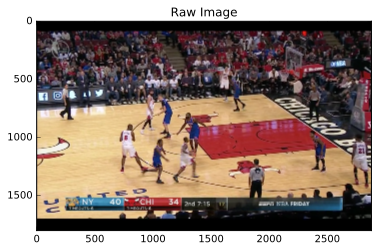

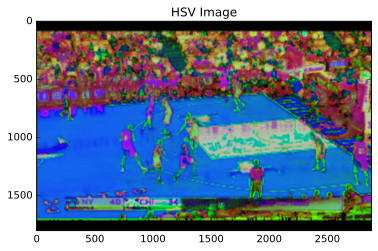

In [6]:
img = cv2.imread('imgs/bulls.jpg')
height, width, channels = img.shape

hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

display_img(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 'Raw Image')
display_img(hsv_img, 'HSV Image')

## Plot HSV Distributions

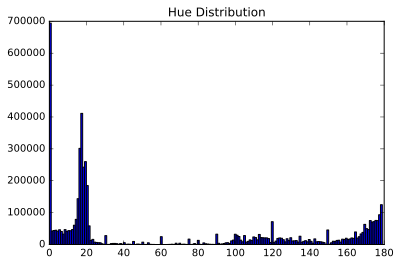

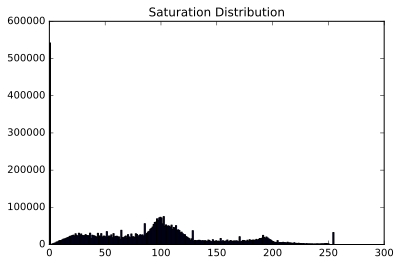

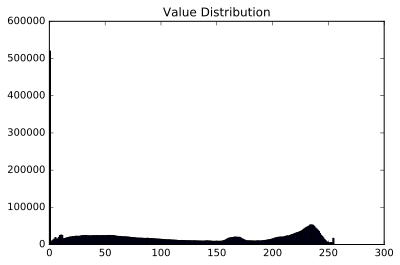

In [7]:
# Create H, S, and V arrays from HSV image
hue_array, saturation_array, value_array = create_hsv_arrays(hsv_img)

# Plot Hue Array
plot_hsv_arrays(hue_array, saturation_array, value_array)

## Create mask to identify court and display mask

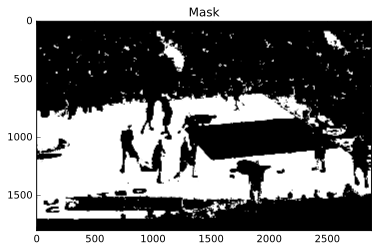

In [8]:
# BGR color of the court in img
COURT_BGR_COLOR = np.uint8([[[152,204,238]]])

# Mask returned from identifying court color in HSV image
mask = create_mask(COURT_BGR_COLOR, hsv_img)

display_img(mask, 'Mask', 'gray')

## Try Blurring Image First

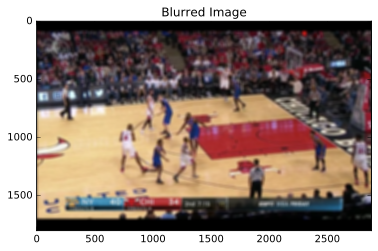

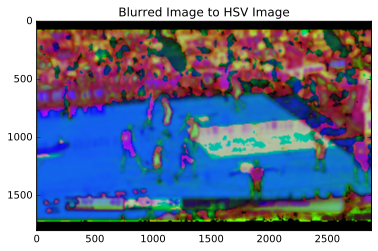

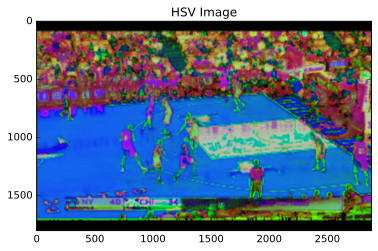

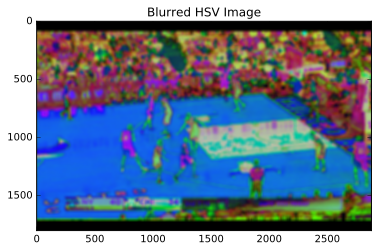

In [9]:
BLUR_KERNEL = 30

blurred_img = cv2.blur(img, (BLUR_KERNEL, BLUR_KERNEL))
blurred_hsv_img = cv2.blur(hsv_img, (BLUR_KERNEL, BLUR_KERNEL))
blurred_img_to_hsv = cv2.cvtColor(blurred_img, cv2.COLOR_BGR2HSV)


display_img(cv2.cvtColor(blurred_img, cv2.COLOR_BGR2RGB), 'Blurred Image')
display_img(blurred_img_to_hsv, 'Blurred Image to HSV Image')
display_img(hsv_img, 'HSV Image')
display_img(blurred_hsv_img, 'Blurred HSV Image')

## Compare mask for blurred-to-HSV with blurred-HSV

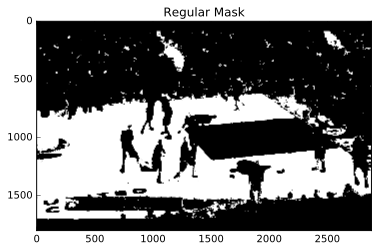

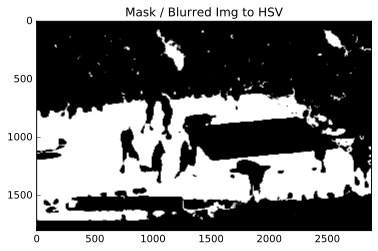

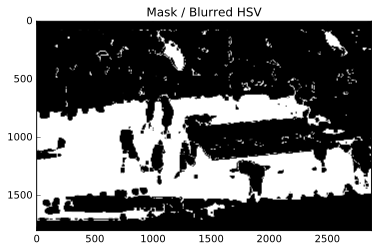

In [7]:
blurred_img_to_hsv_mask = create_mask(COURT_BGR_COLOR, blurred_img_to_hsv)
blurred_hsv_mask = create_mask(COURT_BGR_COLOR, blurred_hsv_img)

display_img(mask, 'Regular Mask', 'gray')
display_img(blurred_img_to_hsv_mask, 'Mask / Blurred Img to HSV', 'gray')
display_img(blurred_hsv_mask, 'Mask / Blurred HSV', 'gray')

## Test Erosion, Dilation, Opening, Closing on mask for blurred-to-HSV

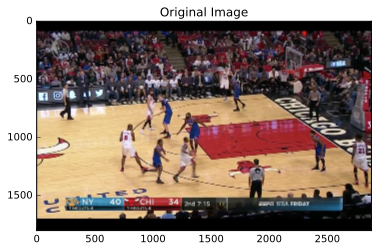

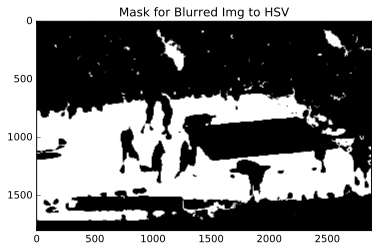

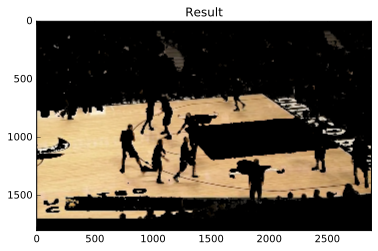

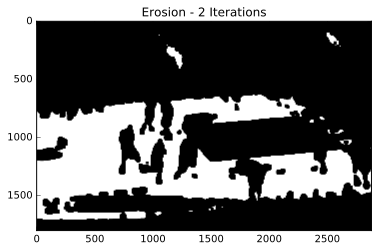

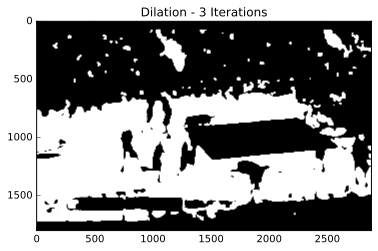

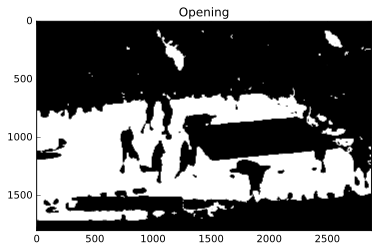

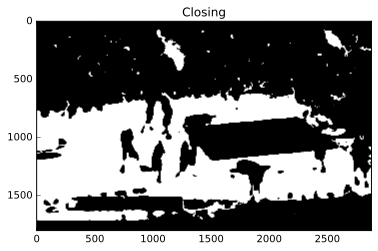

(<matplotlib.image.AxesImage at 0x7eff3269e910>,
 None)

In [8]:
# Bitwise-AND mask and original image
res = cv2.bitwise_and(img,img, mask=mask)

display_img(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 'Original Image')
display_img(blurred_img_to_hsv_mask, 'Mask for Blurred Img to HSV', 'gray')
display_img(cv2.cvtColor(res, cv2.COLOR_BGR2RGB), 'Result')

# Erosion
kernel = np.ones((5,5),np.uint8)
erosions2 = cv2.erode(blurred_img_to_hsv_mask, kernel,iterations = 5)
plt.imshow(erosions2, cmap='gray'), plt.title('Erosion - 2 Iterations'), plt.show()

# Dilation
dilation = cv2.dilate(blurred_img_to_hsv_mask, kernel,iterations = 3)
plt.imshow(dilation, cmap='gray'), plt.title('Dilation - 3 Iterations'), plt.show()

# Opening
opening = cv2.morphologyEx(blurred_img_to_hsv_mask, cv2.MORPH_OPEN, kernel)
plt.imshow(opening, cmap='gray'), plt.title('Opening'), plt.show()

# Closing
closing = cv2.morphologyEx(blurred_img_to_hsv_mask, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing, cmap='gray'), plt.title('Closing'), plt.show()

## Compare Canny for blurred-to-HSV with blurred-HSV

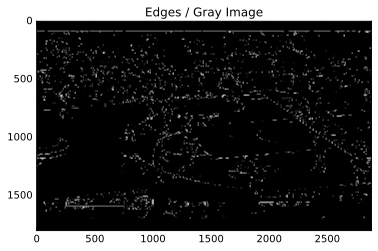

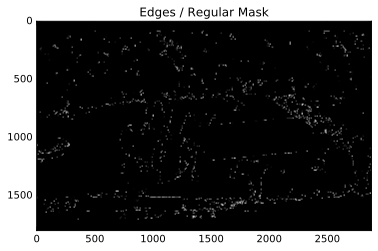

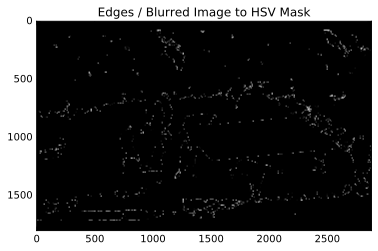

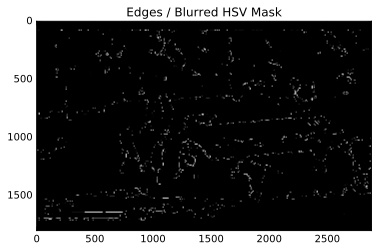

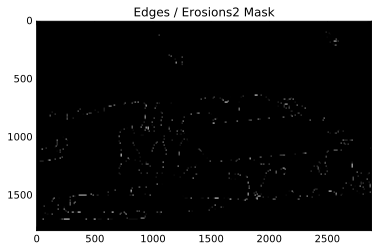

In [9]:
gray_img_edges = canny(cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cv2.COLOR_RGB2GRAY))
reg_edges = canny(mask)
blurred_img_to_hsv_edges = canny(blurred_img_to_hsv_mask)
blurred_hsv_edges = canny(blurred_hsv_mask)
erosions2_edges = canny(erosions2)

display_img(gray_img_edges, 'Edges / Gray Image', 'gray')
display_img(reg_edges, 'Edges / Regular Mask', 'gray')
display_img(blurred_img_to_hsv_edges, 'Edges / Blurred Image to HSV Mask', 'gray')
display_img(blurred_hsv_edges, 'Edges / Blurred HSV Mask', 'gray')
display_img(erosions2_edges, 'Edges / Erosions2 Mask', 'gray')

## Hugh Line Detector on Variety of Images

In [10]:
# Create 3 image copy
img_copy1, img_copy2, img_copy3, img_copy4, img_copy5, img_copy6 = [cv2.imread('imgs/bulls.jpg'), cv2.imread('imgs/bulls.jpg'), cv2.imread('imgs/bulls.jpg'), cv2.imread('imgs/bulls.jpg'), cv2.imread('imgs/bulls.jpg'), cv2.imread('imgs/bulls.jpg')]

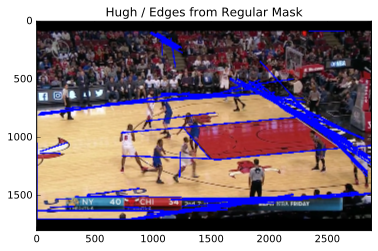

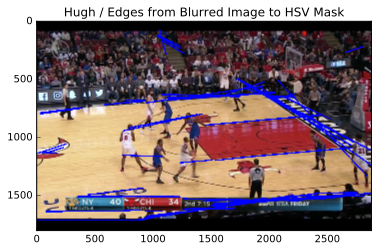

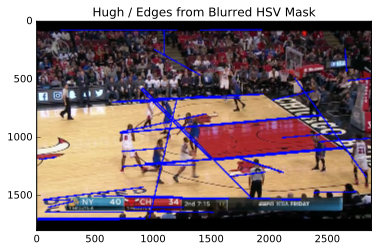

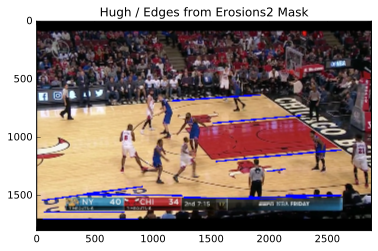

In [11]:
# Default minLineLength = 100 & maxLineGap = 150

hugh(edges = reg_edges, input_img = img_copy1)
display_img(cv2.cvtColor(img_copy1, cv2.COLOR_BGR2RGB), 'Hugh / Edges from Regular Mask')

hugh(edges = blurred_img_to_hsv_edges, input_img = img_copy2)
display_img(cv2.cvtColor(img_copy2, cv2.COLOR_BGR2RGB), 'Hugh / Edges from Blurred Image to HSV Mask')

hugh(edges = blurred_hsv_edges, input_img = img_copy3)
display_img(cv2.cvtColor(img_copy3, cv2.COLOR_BGR2RGB), 'Hugh / Edges from Blurred HSV Mask')

hugh(edges = erosions2_edges, input_img = img_copy4)
display_img(cv2.cvtColor(img_copy4, cv2.COLOR_BGR2RGB), 'Hugh / Edges from Erosions2 Mask')

## Experiment with Different minLineLength and maxLineGap Values

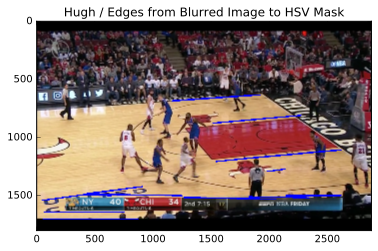

In [12]:
image_copy4 = cv2.imread('imgs/bulls.jpg')

minLineLength = 250
maxLineGap = 150

hugh(edges = erosions2_edges, input_img = img_copy4, minLineLength = minLineLength, maxLineGap = maxLineGap)
display_img(cv2.cvtColor(img_copy4, cv2.COLOR_BGR2RGB), 'Hugh / Edges from Blurred Image to HSV Mask')



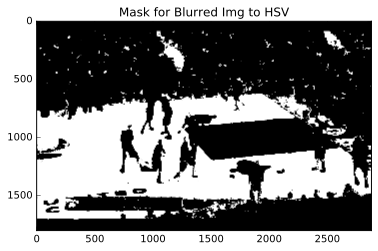

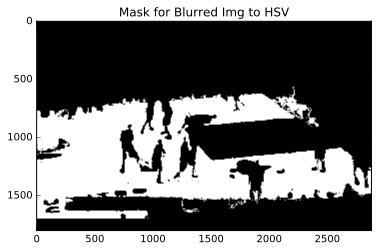

In [13]:
blurred_img_to_hsv_mask = create_mask(COURT_BGR_COLOR, blurred_img_to_hsv)

min_area = (height * width) / 3
display_img(mask, 'Mask for Blurred Img to HSV', 'gray')

_, contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


for i in range(len(contours)):
    tmp_area = cv2.contourArea(contours[i])
    if tmp_area < min_area:
        cv2.drawContours(mask, contours, i, (0, 0, 0), -1)
        
display_img(mask, 'Mask for Blurred Img to HSV', 'gray')

In [14]:
filled_contours_edges = canny(mask)

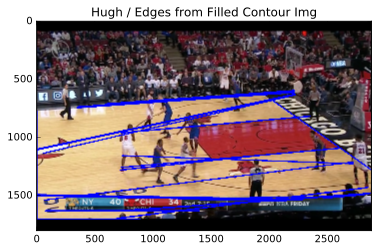

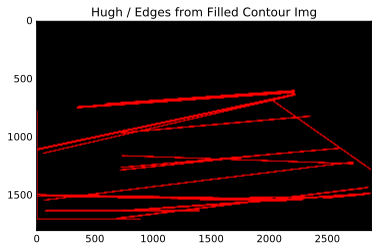

In [16]:
image_copy6 = cv2.imread('imgs/bulls.jpg')
empty_img = np.zeros([height,width,3], dtype=np.uint8)
img.fill(255) 

minLineLength = 100
maxLineGap = 500

hugh(edges = filled_contours_edges, input_img = img_copy6, minLineLength = minLineLength, maxLineGap = maxLineGap)
hugh(edges = filled_contours_edges, input_img = empty_img, minLineLength = minLineLength, maxLineGap = maxLineGap)

display_img(cv2.cvtColor(img_copy6, cv2.COLOR_BGR2RGB), 'Hugh / Edges from Filled Contour Img')
display_img(empty_img, 'Hugh / Edges from Filled Contour Img')